In [ ]:
# Importamos librerías a emplear
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Cargamos el dataset
from google.colab import files
uploaded = files.upload()

Saving dataset_phishing.csv to dataset_phishing.csv


In [ ]:
# Leemos la BD
df = pd.read_csv('dataset_phishing.csv', sep=',')
df.head()


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [ ]:
# Convertimos variable target
df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

status
0    5715
1    5715
Name: count, dtype: int64


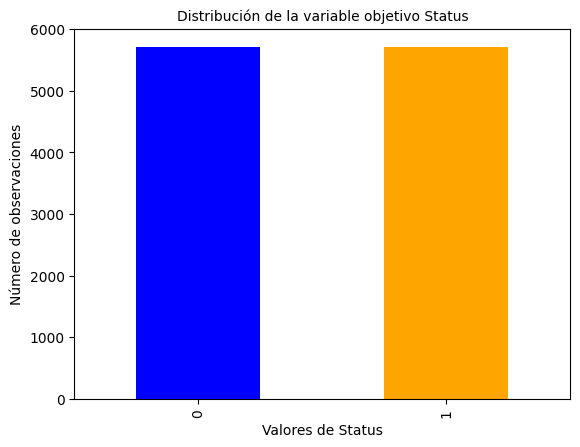

In [ ]:
# Validamos que el dataset esté equilibrado
print(df['status'].value_counts())
df['status'].value_counts().plot(kind = 'bar', color = ['blue', 'orange'])
xlabel = plt.xlabel('Valores de Status')
ylabel = plt.ylabel('Número de observaciones')
plt.title('Distribución de la variable objetivo Status', fontsize = 10)
plt.show()

In [ ]:
# Dividimos nuestro dataset en entrenamiento y testeo
x = df
x = x.drop('status', axis = 1)
y = df['status']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

**Exploración de datos**

In [ ]:
# Validamos valores nulos
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9144 entries, 3886 to 7270
Data columns (total 88 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         9144 non-null   object 
 1   length_url                  9144 non-null   int64  
 2   length_hostname             9144 non-null   int64  
 3   ip                          9144 non-null   int64  
 4   nb_dots                     9144 non-null   int64  
 5   nb_hyphens                  9144 non-null   int64  
 6   nb_at                       9144 non-null   int64  
 7   nb_qm                       9144 non-null   int64  
 8   nb_and                      9144 non-null   int64  
 9   nb_or                       9144 non-null   int64  
 10  nb_eq                       9144 non-null   int64  
 11  nb_underscore               9144 non-null   int64  
 12  nb_tilde                    9144 non-null   int64  
 13  nb_percent                  9144 no

In [ ]:
# Creamos función para identificar variables categóricas
def binaria(columna):
    return columna.nunique() == 2

binaria = pd.DataFrame({col: [binaria(x_train[col])] for col in x_train.columns}).T
binaria.columns = ['binaria']

In [ ]:
# Seleccionamos variables categóricas (binarias)
x_bin = x_train[binaria[binaria['binaria'] == True].index]
x_bin = x_bin.drop(['nb_tilde', 'nb_star', 'nb_dslash', 'nb_external_redirection'], axis = 1)


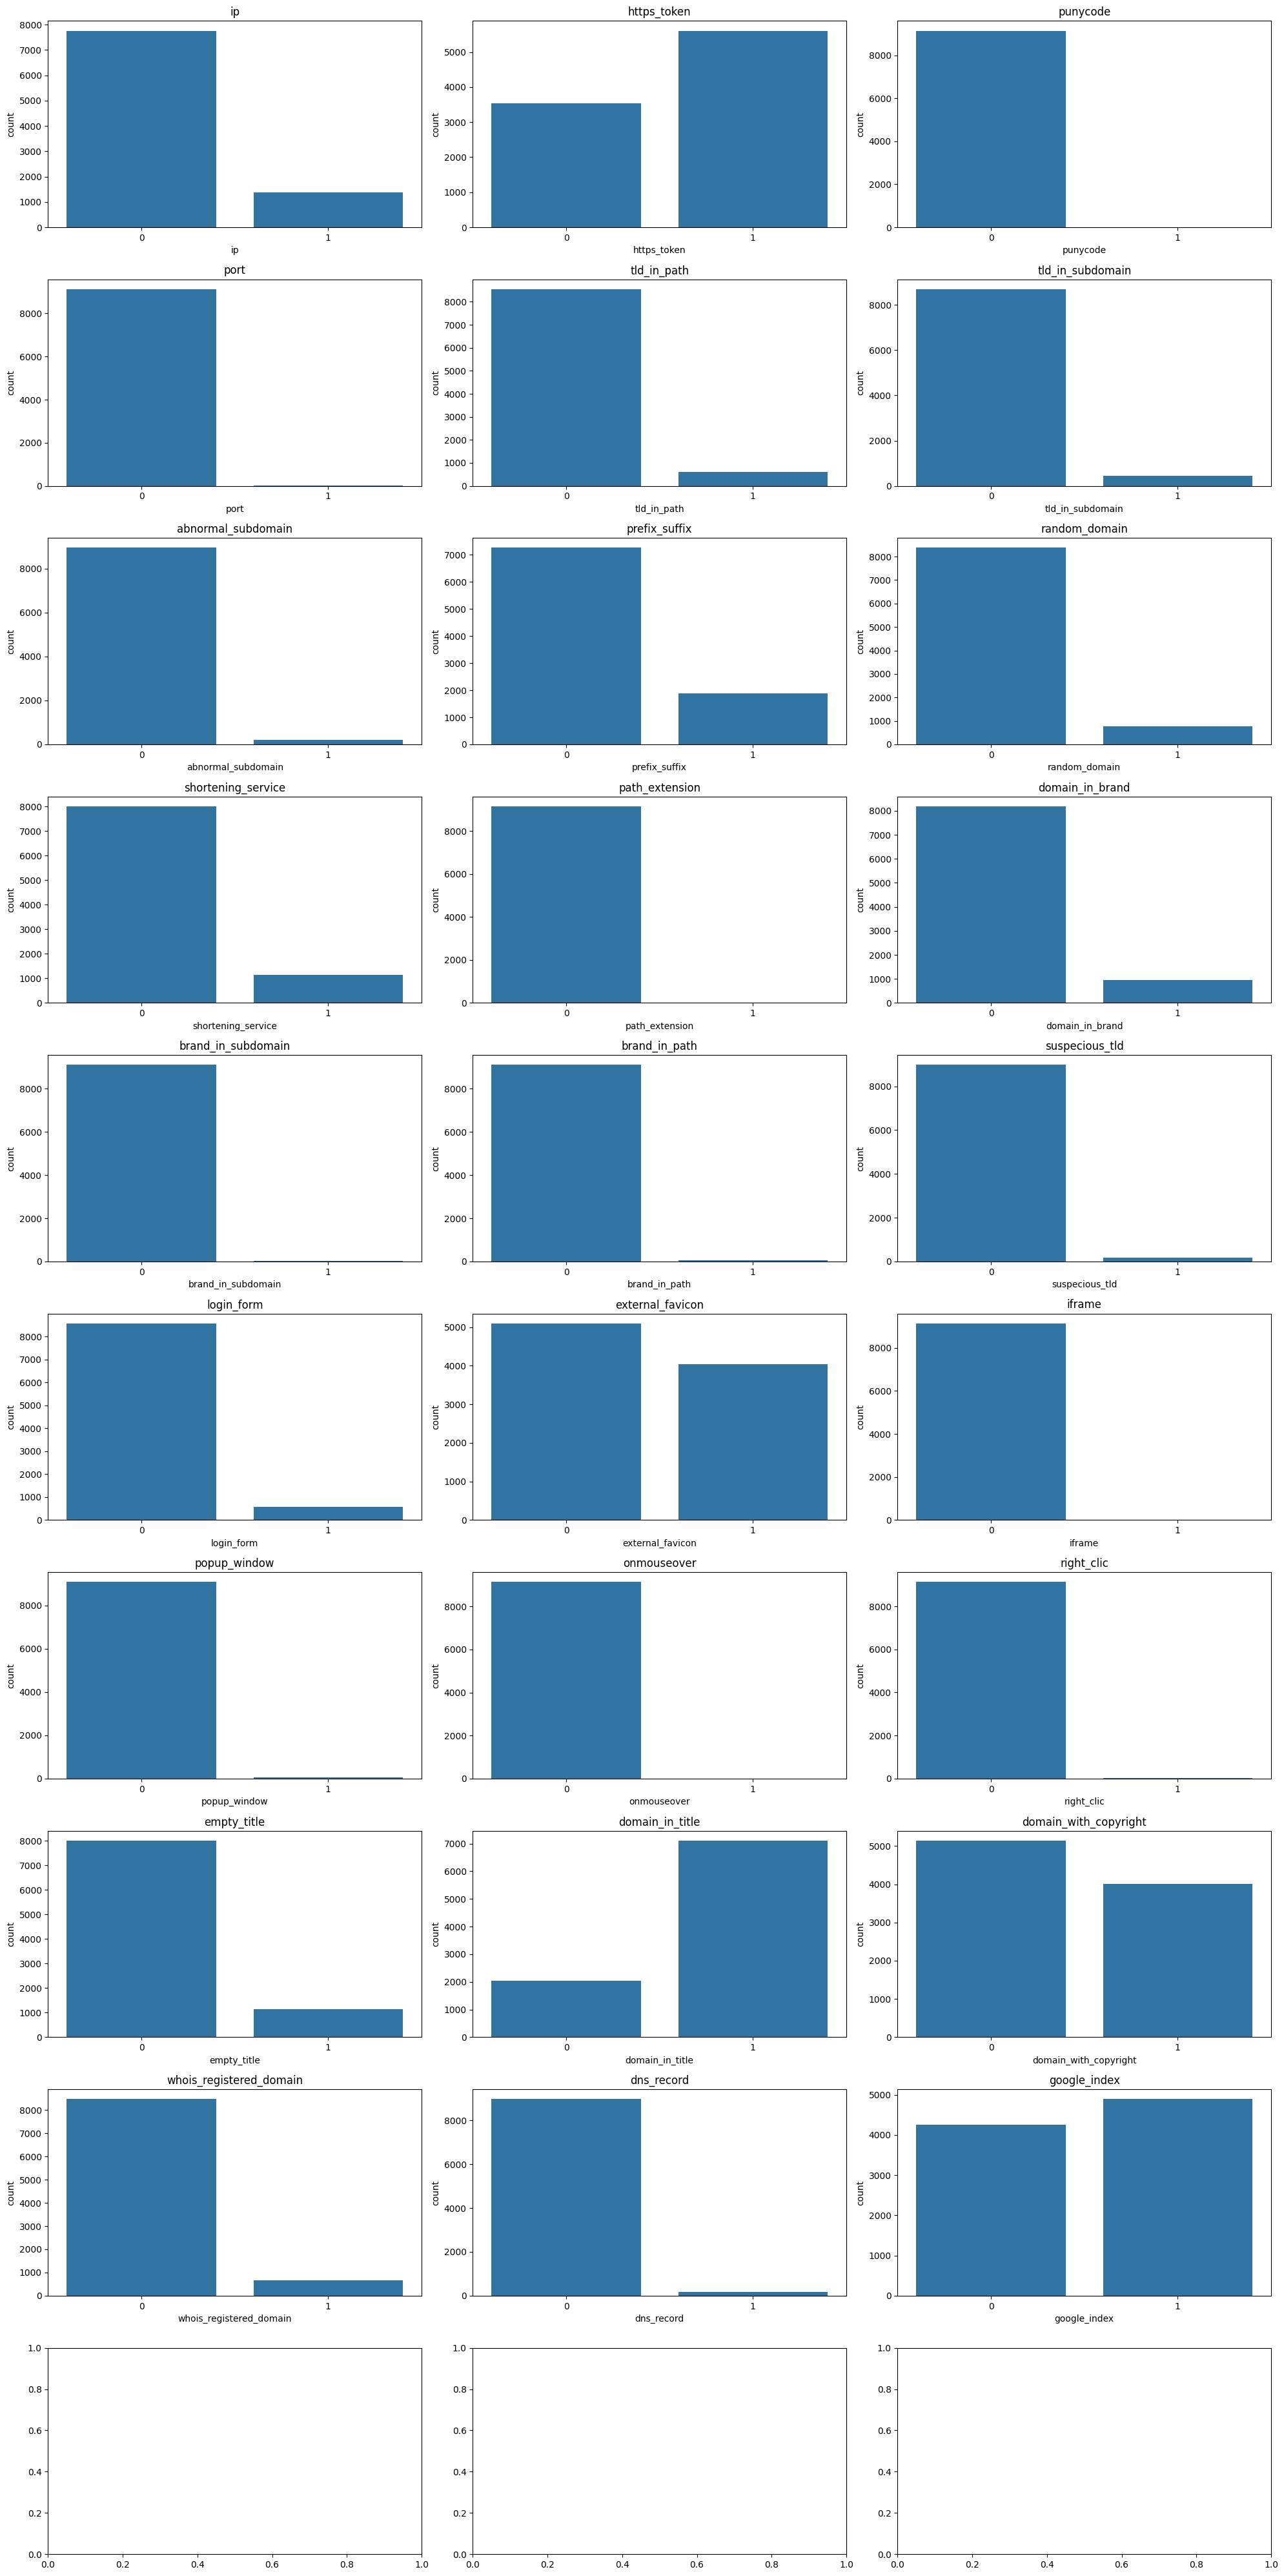

In [ ]:
# Distribuciones de variables categóricas
fig, axes = plt.subplots(nrows = len(x_bin.columns) // 3 + 1, ncols = 3, figsize = (20, 40))
axes = axes.flatten()

for i, column in enumerate(x_bin.columns):
  sns.countplot(data = x_bin, x = column, ax = axes[i])
  axes[i].set_title(f'{column}')

plt.tight_layout()
plt.show()

In [ ]:
# Estadistico descriptivos de variables categóricas
x_bin.describe()

,ip,https_token,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,prefix_suffix,random_domain,shortening_service,path_extension,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,login_form,external_favicon,iframe,popup_window,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,dns_record,google_index
count,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000
mean,0.151684,0.613408,0.000109,0.002406,0.065398,0.048775,0.020997,0.206255,0.084318,0.124234,0.000219,0.104659,0.004046,0.004921,0.018045,0.062664,0.442585,0.001422,0.006124,0.001203,0.001312,0.124234,0.777450,0.437555,0.073053,0.018810,0.535105
std,0.358734,0.486996,0.010458,0.048994,0.247240,0.215409,0.143383,0.404638,0.277879,0.329867,0.014788,0.306130,0.063486,0.069983,0.133120,0.242371,0.496720,0.037681,0.078022,0.034665,0.036204,0.329867,0.415981,0.496112,0.260238,0.135861,0.498793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Seleccionamos variables numéricas
columns_uniques = x_train.columns.difference(x_bin.columns)
x_num = x_train[columns_uniques]
x_num = x_num.drop(['url'], axis = 1)

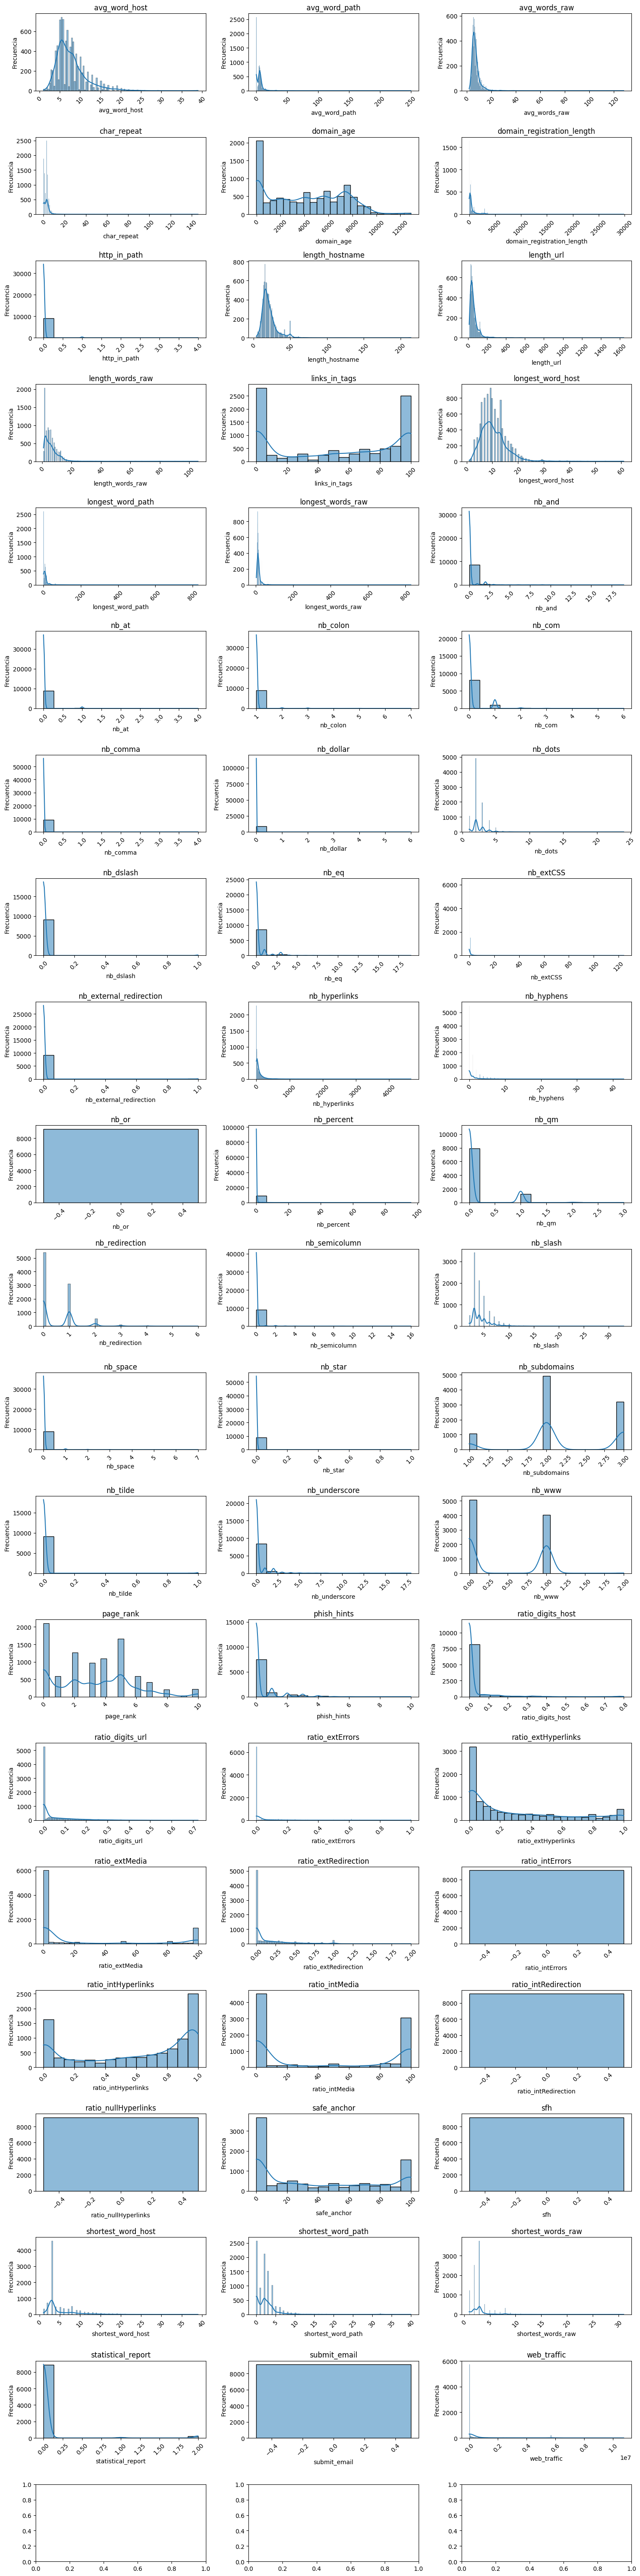

In [ ]:
# Distribuciones de variables numéricas
fig, axes = plt.subplots(nrows = len(x_num.columns) // 3 + 1, ncols = 3, figsize = (15, 60))
axes = axes.flatten()

for i, column in enumerate(x_num.columns):
  sns.histplot(x_num[column], kde = True, ax = axes[i])
  axes[i].set_title(f'{column}')
  axes[i].set_xlabel(column)
  axes[i].set_ylabel('Frecuencia')
  axes[i].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()

In [ ]:
# Estadistico descriptivos de variables numéricas
pd.set_option('display.max_columns', 100)
x_num.describe()

,avg_word_host,avg_word_path,avg_words_raw,char_repeat,domain_age,domain_registration_length,http_in_path,length_hostname,length_url,length_words_raw,links_in_tags,longest_word_host,longest_word_path,longest_words_raw,nb_and,nb_at,nb_colon,nb_com,nb_comma,nb_dollar,nb_dots,nb_dslash,nb_eq,nb_extCSS,nb_external_redirection,nb_hyperlinks,nb_hyphens,nb_or,nb_percent,nb_qm,nb_redirection,nb_semicolumn,nb_slash,nb_space,nb_star,nb_subdomains,nb_tilde,nb_underscore,nb_www,page_rank,phish_hints,ratio_digits_host,ratio_digits_url,ratio_extErrors,ratio_extHyperlinks,ratio_extMedia,ratio_extRedirection,ratio_intErrors,ratio_intHyperlinks,ratio_intMedia,ratio_intRedirection,ratio_nullHyperlinks,safe_anchor,sfh,shortest_word_host,shortest_word_path,shortest_words_raw,statistical_report,submit_email,web_traffic
count,9144.000000,9144.000000,9144.00000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.0,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.000000,9144.0,9144.000000,9144.000000,9144.0,9144.0,9144.000000,9144.0,9144.000000,9144.000000,9144.000000,9144.000000,9144.0,9.144000e+03
mean,7.683961,5.125661,7.28115,2.933290,4066.599628,498.207787,0.017498,21.164698,61.445101,6.251969,51.982434,10.479003,10.679243,15.529746,0.167651,0.022638,1.028653,0.127734,0.004046,0.001859,2.485236,0.006452,0.298556,0.803915,0.002843,87.492345,1.005687,0.0,0.120079,0.141842,0.500875,0.061242,4.295494,0.030512,0.000766,2.231846,0.006780,0.319444,0.445866,3.199256,0.327209,0.024582,0.052980,0.062440,0.277841,23.294441,0.157505,0.0,0.600878,42.497335,0.0,0.0,37.334664,0.0,5.020560,2.405621,3.121938,0.058508,0.0,8.569714e+05
std,3.604809,7.454986,4.29144,4.815817,3120.390811,842.801859,0.174122,11.087829,56.780708,5.661990,41.542077,4.982985,23.956654,22.985394,0.849110,0.158714,0.245376,0.380655,0.107088,0.078936,1.392155,0.080071,1.020566,2.889473,0.053251,170.417536,2.094604,0.0,1.442020,0.363040,0.691505,0.579811,1.896985,0.285354,0.027659,0.640129,0.082068,1.101037,0.501469,2.536768,0.839459,0.091511,0.089228,0.156533,0.320304,38.461557,0.264469,0.0,0.376533,46.219694,0.0,0.0,39.186379,0.0,3.949813,3.007529,2.209943,0.327008,0.0,1.993153e+06
min,1.000000,0.000000,2.00000,0.000000,-12.000000,-1.000000,0.000000,4.000000,12.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.0,0.000000e+00
25%,5.250000,0.000000,5.25000,1.000000,965.000000,86.000000,0.000000,15.000000,33.000000,2.000000,0.000000,7.000000,0.000000,9.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.223924,0.000000,0.0,0.0,0.000000,0.0,3.000000,0.000000,2.000000,0.000000,0.0,0.000000e+00
50%,7.000000,4.888889,6.50000,3.000000,3993.000000,244.500000,0.000000,19.000000,47.000000,5.000000,60.000000,10.000000,7.000000,11.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000

In [ ]:
# Validamos valores negativos
print(x_num.loc[x_num['domain_registration_length'] < 0].shape[0])
print(x_num.loc[x_num['domain_age'] < 0].shape[0])


37
1483


In [ ]:
# Seleccionamos variables numéricas con mayor variabilidad
selector = VarianceThreshold(threshold = 0.01)
x_num_red = pd.DataFrame(selector.fit_transform(x_num), columns = x_num.columns[selector.get_support()])
num_cols = x_num_red.columns

In [ ]:
print(x_num.shape[1])
print(x_num_red.shape[1])
print(x_bin.shape[1])

60
47
27


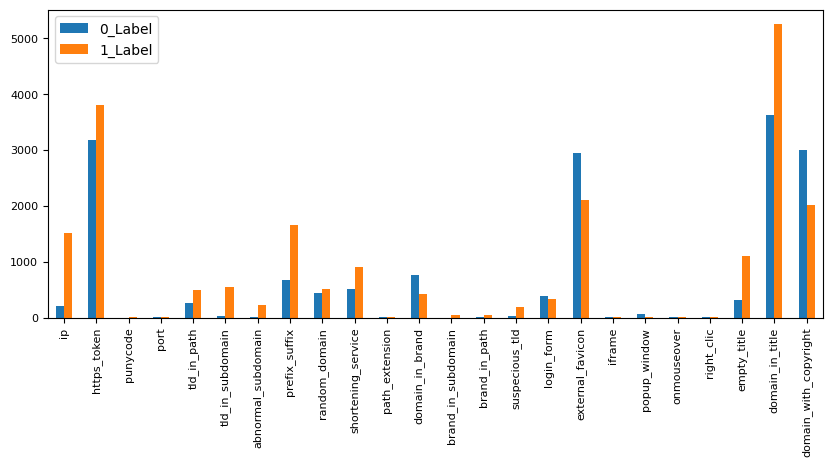

In [ ]:
# Graficamos la distribución de las variables categóricas
bin_cols = x_bin.columns
distr_bin = df.groupby('status')[bin_cols].sum().reset_index().T
distr_bin.rename(columns = {0:'0_Label', 1:"1_Label"}, inplace = True)
plt.rcParams['axes.facecolor'] = 'w'
ax = distr_bin[1:-3][['0_Label', '1_Label']].plot(kind = 'bar', figsize = (10, 4), legend = True, fontsize = 8)
plt.show()

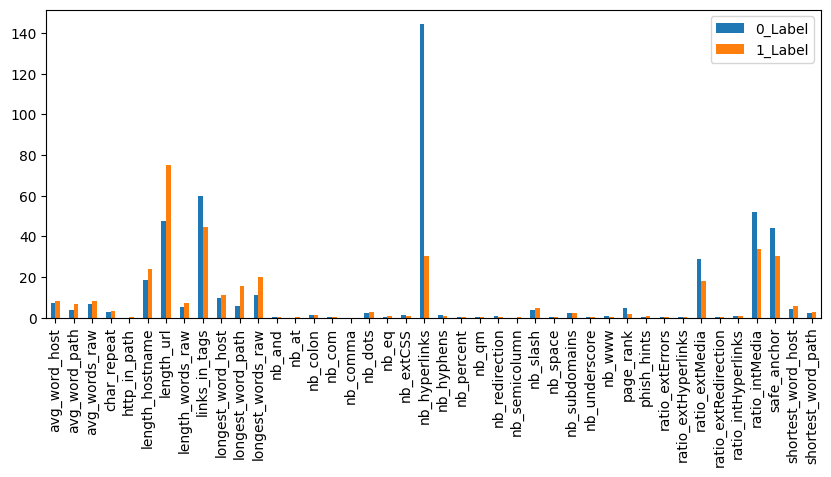

In [ ]:
# Graficamos la distribución de las medias de las variables numéricas más relevantes
num_cols_2 = x_num_red.drop(['domain_registration_length', 'domain_age'], axis = 1).columns
distr_num = df.groupby('status')[num_cols_2].mean().reset_index().T
distr_num.rename(columns = {0:'0_Label', 1:"1_Label"}, inplace = True)
plt.rcParams['axes.facecolor'] = 'w'
ax = distr_num[1:-3][['0_Label', '1_Label']].plot(kind = 'bar', figsize = (10, 4), legend = True, fontsize = 10)
plt.show()

**Preprocesamiento**

In [ ]:
# Seleccionamos nuestra data de entremiento
select_columns = x_bin.columns.tolist() + x_num_red.columns.tolist()
x_train = x_train[select_columns]

In [ ]:
# Reemplazamos los valores negativos por nulos para proceder a reemplazarlos
x_train_imputed = x_train.copy()
for col in ['domain_age', 'domain_registration_length']:
    x_train_imputed[col] = x_train_imputed[col].apply(lambda x: np.nan if x < 0 else x)

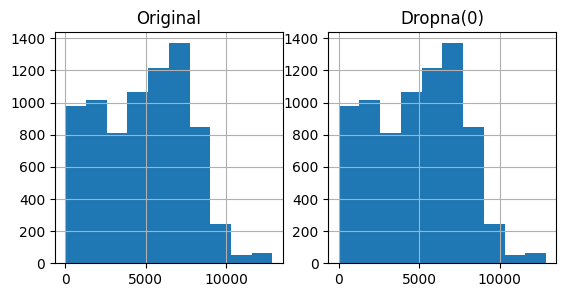

In [ ]:
# Eliminamos los nulos para la variable 'domain_age'
plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
x_train_imputed['domain_age'].hist()
plt.title('Original')

plt.subplot(1,3,2)
x_train_imputed['domain_age'].dropna().hist()
plt.title('Dropna(0)')

plt.show()


Text(0.5, 1.0, 'Fillna(mediana)')

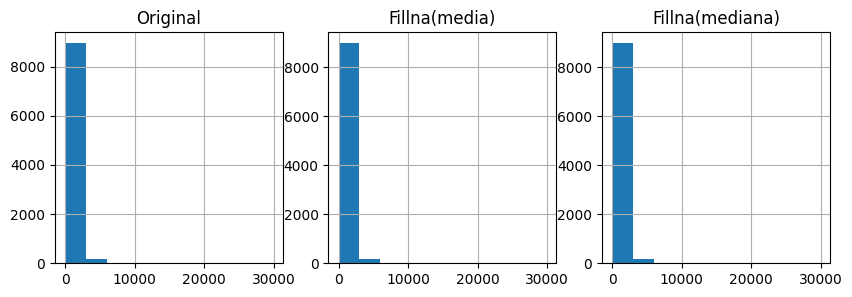

In [ ]:
# Eliminamos los nulos para la variable 'domain_registration_length'
plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
x_train_imputed['domain_registration_length'].hist()
plt.title('Original')

plt.subplot(1,3,2)
x_train_imputed['domain_registration_length'].fillna(x_train['domain_registration_length'].mean()).hist()
plt.title('Fillna(media)')

plt.subplot(1,3,3)
x_train_imputed['domain_registration_length'].fillna(x_train['domain_registration_length'].median()).hist()
plt.title('Fillna(mediana)')


In [ ]:
# Reemplazamos y eliminamos los valores
x_train_imputed['domain_registration_length'] = x_train_imputed['domain_registration_length'].fillna(x_train['domain_registration_length'].mean())
x_train_imputed = x_train_imputed.dropna()
y_train = y_train[x_train_imputed.index]

**Método de filtrado**

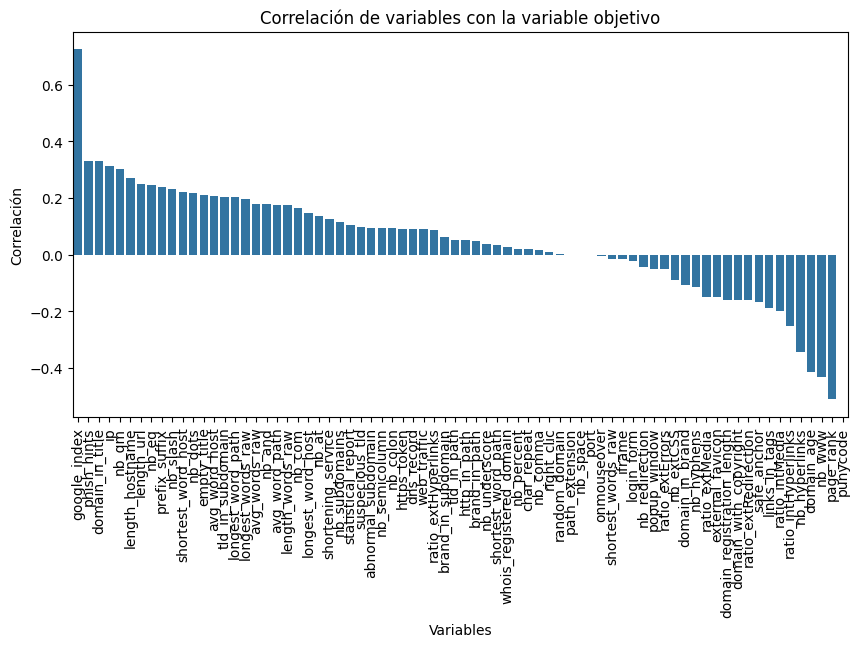

In [ ]:
# Calculamos la correlación con la variable target
df_train = x_train_imputed.copy()
df_train['status'] = y_train

corr_target = df_train.corr()['status'].drop('status')
corr_order = corr_target.sort_values(ascending = False)

# Graficamos
plt.figure(figsize = (10, 5))
plt.xticks(rotation = 90)
sns.barplot(x = corr_order.index, y = corr_order.values)
plt.title('Correlación de variables con la variable objetivo')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.show()

In [ ]:
# Las variables a emplear serán aquellas con un valor de correlación > 0.2
threshold = 0.2
relevant_features = corr_target[abs(corr_target) > threshold].index.tolist()
x_train = x_train_imputed[relevant_features]
x_test = x_test[relevant_features]

In [ ]:
# Escalamos el dataset
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
# Seleccionamos los clasificadores a evaluar
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

In [ ]:
# Evaluamos diferentes parámetros
param_grids = {
    'Logistic Regression': {
        'penalty': ['l1', 'l2', 'none'],
        'C': [0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20],
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 7]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'p': [1, 2]
    }
}

In [ ]:
# Entrenamos modelos
results = {}
for name, clf in classifiers.items():
    grid_search = GridSearchCV(estimator = clf, param_grid = param_grids[name], cv = 5, n_jobs = -1, scoring = 'recall')
    grid_search.fit(x_train_scaled, y_train)
    results[name] = grid_search

In [ ]:
# Medir el tiempo de predicción para una instancia
prediction_times = {}

for name, grid_search in results.items():
    start_time = time.time()
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict([x_test_scaled[0]])
    end_time = time.time()
    prediction_times[name] = end_time - start_time
    print(f"Tiempo de predicción para {name}: {prediction_times[name]} segundos")

Tiempo de predicción para Logistic Regression: 0.000591278076171875 segundos
Tiempo de predicción para Random Forest: 0.061635732650756836 segundos
Tiempo de predicción para Gradient Boosting: 0.00124359130859375 segundos
Tiempo de predicción para SVM: 0.0007069110870361328 segundos
Tiempo de predicción para KNN: 0.0060062408447265625 segundos


In [ ]:
# Resultados
for name, grid_search in results.items():
    print(f"{name}:")
    print("Best Parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_accuracy)
    test_precision = precision_score(y_test, y_pred)
    print("Test Precision:", test_precision)
    test_recall = recall_score(y_test, y_pred)
    print("Test Recall:", test_recall)
    test_f1 = f1_score(y_test, y_pred)
    print("Test F1 Score:", test_f1)
    print("Confusion Matrix", confusion_matrix(y_test, y_pred))
    print()

Logistic Regression:
Best Parameters: {'C': 10, 'penalty': 'l2'}
Test Accuracy: 0.9365704286964129
Test Precision: 0.9248704663212435
Test Recall: 0.9486271036315324
Test F1 Score: 0.9365981635330127
Confusion Matrix [[1070   87]
 [  58 1071]]

Random Forest:
Best Parameters: {'max_depth': None, 'n_estimators': 500}
Test Accuracy: 0.9588801399825022
Test Precision: 0.9465056082830026
Test Recall: 0.9716563330380869
Test F1 Score: 0.958916083916084
Confusion Matrix [[1095   62]
 [  32 1097]]

Gradient Boosting:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Test Accuracy: 0.9601924759405074
Test Precision: 0.9481865284974094
Test Recall: 0.9725420726306466
Test F1 Score: 0.960209881941408
Confusion Matrix [[1097   60]
 [  31 1098]]

SVM:
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.9453193350831146
Test Precision: 0.9372822299651568
Test Recall: 0.9530558015943312
Test F1 Score: 0.9451032059727712
Confusion Matrix [[1085   72]
 [  53 1076]]


In [ ]:
# Medir el tiempo de predicción
start_time = time.time()
y_pred = best_model.predict(x_test)
end_time = time.time()

# Tiempo de predicción
prediction_time = end_time - start_time
print("Tiempo de predicción:", prediction_time, "segundos")

Tiempo de predicción: 0.5829136371612549 segundos


**Método de envoltura**

In [ ]:
# Entrenamos el clasificador con todas las características
lr = LogisticRegression(solver = 'liblinear')
lr.fit(x_train_imputed, y_train)

SFS_bw = SequentialFeatureSelector(lr, k_features = 'best', forward = False)
SFS_bw.fit(x_train_imputed.to_numpy(), y_train.to_numpy())

x_train.columns[list(SFS_bw.k_feature_idx_)]


Index(['https_token', 'port', 'tld_in_path', 'tld_in_subdomain',
       'abnormal_subdomain', 'prefix_suffix', 'shortening_service',
       'path_extension', 'domain_in_brand', 'brand_in_path', 'suspecious_tld',
       'login_form', 'external_favicon', 'iframe', 'popup_window',
       'onmouseover', 'empty_title', 'domain_in_title',
       'domain_with_copyright', 'google_index', 'avg_word_path',
       'avg_words_raw', 'char_repeat', 'domain_age',
       'domain_registration_length', 'length_hostname', 'links_in_tags',
       'longest_word_host', 'longest_word_path', 'longest_words_raw', 'nb_at',
       'nb_colon', 'nb_com', 'nb_dots', 'nb_eq', 'nb_hyperlinks', 'nb_hyphens',
       'nb_percent', 'nb_qm', 'nb_semicolumn', 'nb_slash', 'nb_space',
       'nb_subdomains', 'nb_underscore', 'nb_www', 'page_rank', 'phish_hints',
       'ratio_extErrors', 'ratio_extRedirection', 'ratio_intHyperlinks',
       'ratio_intMedia', 'safe_anchor', 'shortest_word_path',
       'statistical_report'],


In [ ]:
# Variables relevantes
relevant_features = x_train.columns[list(SFS_bw.k_feature_idx_)]
x_train = x_train_imputed[relevant_features]
x_test = x_test[relevant_features]

In [ ]:
# Escalamos el dataset
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
# Seleccionamos los clasificadores a evaluar
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

In [ ]:
# Evaluamos diferentes parámetros
param_grids = {
    'Logistic Regression': {
        'penalty': ['l1', 'l2', 'none'],
        'C': [0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20],
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 7]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'p': [1, 2]
    }
}

In [ ]:
# Medimos los resultados
results = {}
for name, clf in classifiers.items():
    grid_search = GridSearchCV(estimator = clf, param_grid = param_grids[name], cv = 5, n_jobs = -1, scoring = 'recall')
    grid_search.fit(x_train_scaled, y_train)
    results[name] = grid_search

In [ ]:
# Resultados
for name, grid_search in results.items():
    print(f"{name}:")
    print("Best Parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_accuracy)
    test_precision = precision_score(y_test, y_pred)
    print("Test Precision:", test_precision)
    test_recall = recall_score(y_test, y_pred)
    print("Test Recall:", test_recall)
    test_f1 = f1_score(y_test, y_pred)
    print("Test F1 Score:", test_f1)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print()

Logistic Regression:
Best Parameters: {'C': 10, 'penalty': 'l2'}
Test Accuracy: 0.9466316710411199
Test Precision: 0.935930735930736
Test Recall: 0.9574844995571302
Test F1 Score: 0.946584938704028
Confusion Matrix:
 [[1083   74]
 [  48 1081]]

Random Forest:
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Test Accuracy: 0.9619422572178478
Test Precision: 0.9570175438596491
Test Recall: 0.9663418954827281
Test F1 Score: 0.9616571176729837
Confusion Matrix:
 [[1108   49]
 [  38 1091]]

Gradient Boosting:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Test Accuracy: 0.9619422572178478
Test Precision: 0.9522569444444444
Test Recall: 0.9716563330380869
Test F1 Score: 0.9618588338448049
Confusion Matrix:
 [[1102   55]
 [  32 1097]]

SVM:
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.9545056867891514
Test Precision: 0.945264986967854
Test Recall: 0.9636846767050488
Test F1 Score: 0.9543859649122807
Confusion Matrix:
 [[1094   63]
 [  41 

In [ ]:
# Medir el tiempo de predicción para el mejor modelo
prediction_times = {}

for name, grid_search in results.items():
    start_time = time.time()
    y_pred = best_model.predict(x_test_scaled)
    end_time = time.time()
    prediction_times[name] = end_time - start_time
    print(f"Tiempo de predicción para {name}: {prediction_times[name]} segundos")

Tiempo de predicción para Logistic Regression: 1.1679973602294922 segundos
Tiempo de predicción para Random Forest: 1.1398022174835205 segundos
Tiempo de predicción para Gradient Boosting: 1.158231258392334 segundos
Tiempo de predicción para SVM: 1.162102460861206 segundos
Tiempo de predicción para KNN: 1.5625548362731934 segundos
